# Unsupervised Learning Trading Strategy

* Download/Load SP500 stocks prices data.
* Calculate different features and indicators on each stock.
* Aggregate on monthly level and filter top 150 most liquid stocks.
* Calculate Monthly Returns for different time-horizons.
* Download Fama-French Factors and Calculate Rolling Factor Betas.
* For each month fit a K-Means Clustering Algorithm to group similar assets based on their features.
* For each month select assets based on the cluster and form a portfolio based on Efficient Frontier max sharpe ratio optimization.
* Visualize Portfolio returns and compare to SP500 returns.

# All Packages Needed:
* pandas, numpy, matplotlib, statsmodels, pandas_datareader, datetime, yfinance, sklearn, PyPortfolioOpt

## 1. Download/Load SP500 stocks prices data.

In [1]:
from statsmodels.regression.rolling import RollingOLS
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import talib as ta
import requests
from io import StringIO
import time

In [2]:
# URL of the S&P 500 list on Wikipedia
url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'

# Add headers to mimic a browser request
headers = {
    'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/141.0.0.0 Safari/537.36'
}

# Fetch the HTML page
response = requests.get(url, headers=headers)

# Wrap the HTML content using StringIO
html = StringIO(response.text)

# Read tables
tables = pd.read_html(html)
sp500_table = tables[0]

# Clean ticker symbols
tickers = [ticker.replace('.', '-') for ticker in sp500_table['Symbol'].unique()]

In [3]:
START = dt.datetime.today() - dt.timedelta(days=365 * 10)
END = dt.datetime.today()

# Download data in batches
def download_in_batches(tickers, batch_size=100):
    all_data = []
    for i in range(0, len(tickers), batch_size):
        batch = tickers[i:i+batch_size]
        data = yf.download(batch, start=START, end=END, auto_adjust=False)
        data.dropna(how='all', inplace=True)
        stacked = data.stack(level=1, future_stack=True)
        all_data.append(stacked)
        time.sleep(5)
    return pd.concat(all_data)

df = download_in_batches(tickers)
df.index.names = ['date', 'ticker']
df.columns = ['adj close', 'close', 'high', 'low', 'open', 'volume']
df

[*********************100%***********************]  100 of 100 completed
[*********************100%***********************]  100 of 100 completed
[*********************100%***********************]  100 of 100 completed
[*********************100%***********************]  100 of 100 completed
[*********************100%***********************]  100 of 100 completed
[*********************100%***********************]  3 of 3 completed


adj close       close        high         low        open  \
date       ticker                                                               
2015-10-23 A        34.231422   37.110001   37.270000   36.180000   36.500000   
           AAPL     26.760323   29.770000   29.807501   29.082500   29.174999   
           ABBV     33.214188   50.340000   51.730000   48.639999   49.410000   
           ABNB           NaN         NaN         NaN         NaN         NaN   
           ABT      36.114403   43.599998   43.860001   43.189999   43.520000   
...                       ...         ...         ...         ...         ...   
2025-10-16 ZBRA    293.929993  293.929993  297.489990  288.880005  294.989990   
           ZTS     143.259995  143.259995  144.229996  141.169998  141.869995   
2025-10-17 ZBH     101.919998  101.919998  102.099998   99.059998   99.820000   
           ZBRA    293.309998  293.309998  295.420013  290.690002  292.920013   
           ZTS     144.059998  144.059998  144.570007  142.550003  143.130005   

                        volume  
date       ticker               
2015-10-23 A         2732600.0  
           AAPL    237467600.0  
           ABBV     26214800.0  
           ABNB            NaN  
           ABT       9582700.0  
...                        ...  
2025-10-16 ZBRA       423200.0  
           ZTS       3385600.0  
2025-10-17 ZBH       1158700.0  
           ZBRA       413000.0  
           ZTS       3748900.0  

[1263033 rows x 6 columns]

## 2. Calculate features and technical indicators for each stock.

* Garman-Klass Volatility
* RSI
* Bollinger Bands
* ATR
* MACD
* Dollar Volume

\begin{equation}
\text{Garman-Klass Volatility} = \frac{(\ln(\text{High}) - \ln(\text{Low}))^2}{2} - (2\ln(2) - 1)(\ln(\text{Adj Close}) - \ln(\text{Open}))^2
\end{equation}

In [4]:
df['garma_klass_vol'] = (
    ((np.log(df['high']) - np.log(df['low'])) ** 2) / 2
    - ((2 * np.log(2) - 1) * (np.log(df['adj close']) - np.log(df['open'])) ** 2)
)

df['rsi'] = df.groupby(level=1)['adj close'].transform(lambda x: ta.RSI(x.values, timeperiod=20))

<Axes: xlabel='date'>

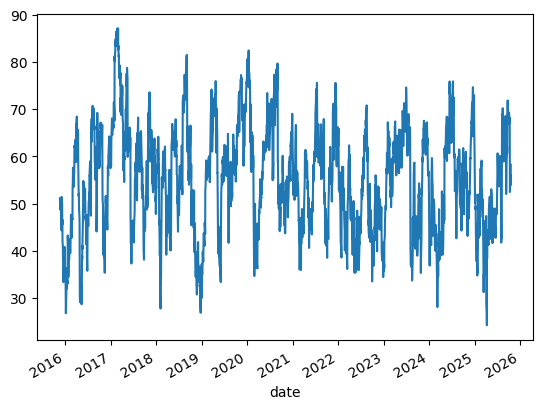

In [5]:
df.xs('AAPL', level=1)['rsi'].plot()

In [6]:
# Compute all BB bands per group
def compute_bbands(x):
    lower, middle, upper = ta.BBANDS(np.log1p(x), timeperiod=20)
    return pd.DataFrame({
        'bb_low': lower,
        'bb_mid': middle,
        'bb_high': upper
    }, index=x.index)

# Apply per symbol (level=1 in MultiIndex)
bb_df = df.groupby(level=1)['adj close'].apply(compute_bbands)

# Drop outer index to align with original df
bb_df.index = bb_df.index.droplevel(0)

# Join bands into df
df[['bb_low', 'bb_mid', 'bb_high']] = bb_df

In [7]:
def compute_atr(df):
    atr = ta.ATR(high=df['high'],
                    low=df['low'],
                    close=df['close'],
                    timeperiod=14)
    atr = atr - atr.mean()
    atr = atr / atr.std()
    return atr

df['atr'] = df.groupby(level=1, group_keys=False).apply(compute_atr)

In [8]:
def compute_macd(df):
    # Assuming ta.MACD returns a tuple of (macd_line, signal_line, histogram)
    macd, signal, histogram = ta.MACD(df['adj close'], 20)
    
    # Now normalize the macd line as intended
    macd = macd - macd.mean()
    macd = macd / macd.std()
    
    return macd

# Apply the function to each group in the DataFrame
df['macd'] = df.groupby(level=1, group_keys=False).apply(compute_macd)

In [9]:
df['dollar_volume'] = (df['adj close'] * df['volume']) / 1e6
df

adj close       close        high         low        open  \
date       ticker                                                               
2015-10-23 A        34.231422   37.110001   37.270000   36.180000   36.500000   
           AAPL     26.760323   29.770000   29.807501   29.082500   29.174999   
           ABBV     33.214188   50.340000   51.730000   48.639999   49.410000   
           ABNB           NaN         NaN         NaN         NaN         NaN   
           ABT      36.114403   43.599998   43.860001   43.189999   43.520000   
...                       ...         ...         ...         ...         ...   
2025-10-16 ZBRA    293.929993  293.929993  297.489990  288.880005  294.989990   
           ZTS     143.259995  143.259995  144.229996  141.169998  141.869995   
2025-10-17 ZBH     101.919998  101.919998  102.099998   99.059998   99.820000   
           ZBRA    293.309998  293.309998  295.420013  290.690002  292.920013   
           ZTS     144.059998  144.059998  144.570007  142.550003  143.130005   

                        volume  garma_klass_vol        rsi    bb_low  \
date       ticker                                                      
2015-10-23 A         2732600.0        -0.001150        NaN       NaN   
           AAPL    237467600.0        -0.002580        NaN       NaN   
           ABBV     26214800.0        -0.059041        NaN       NaN   
           ABNB            NaN              NaN        NaN       NaN   
           ABT       9582700.0        -0.013322        NaN       NaN   
...                        ...              ...        ...       ...   
2025-10-16 ZBRA       423200.0         0.000426  45.345624  5.773110   
           ZTS       3385600.0         0.000193  43.259582  5.000234   
2025-10-17 ZBH       1158700.0         0.000289  55.314439  4.637302   
           ZBRA       413000.0         0.000130  45.087533  5.763042   
           ZTS       3748900.0         0.000083  45.064732  4.998753   

                     bb_mid   bb_high       atr      macd  dollar_volume  
date       ticker                                                         
2015-10-23 A            NaN       NaN       NaN       NaN      93.540785  
           AAPL         NaN       NaN       NaN       NaN    6354.709576  
           ABBV         NaN       NaN       NaN       NaN     870.703286  
           ABNB         NaN       NaN       NaN       NaN            NaN  
           ABT          NaN       NaN       NaN       NaN     346.073487  
...                     ...       ...       ...       ...            ...  
2025-10-16 ZBRA    5.703804  5.634498  0.625795 -0.858603     124.391173  
           ZTS     4.975241  4.950247 -0.029673 -0.965454     485.021037  
2025-10-17 ZBH     4.601706  4.566110 -0.381127 -0.249061     118.094702  
           ZBRA    5.699691  5.636340  0.532636 -0.836114     121.137029  
           ZTS     4.974617  4.950482 -0.069088 -0.913887     540.066525  

[1263033 rows x 14 columns]

## 3. Aggregate to monthly level and filter top 150 most liquid stocks for each month.

* To reduce training time and experiment with features and strategies, we convert the business-daily data to month-end frequency.

* Calculate 5-year rolling average of dollar volume for each stocks before filtering.

In [37]:
last_column = [c for c in df.columns.unique(0) if c not in ['dollar_volume', 'volume', 'open', 'high', 'low', 'close']]
data = pd.concat([
    df.unstack('ticker')['dollar_volume'].resample('ME').mean().stack('ticker', future_stack=True).to_frame('dollar_volume'),
    df.unstack()[last_column].resample('ME').last().stack('ticker', future_stack=True)
], axis=1).dropna()
data

dollar_volume   adj close  garma_klass_vol        rsi  \
date       ticker                                                          
2015-12-31 A          101.811346   38.672337        -0.002370  59.392490   
           AAPL      4222.775799   23.755869        -0.005234  36.082115   
           ABBV       274.525370   39.086395        -0.068133  59.481383   
           ABT        203.483514   37.199501        -0.014272  50.957686   
           ACGL        25.135179   22.108391        -0.001351  33.335821   
...                          ...         ...              ...        ...   
2025-10-31 XYZ        437.946863   75.199997         0.000348  48.793354   
           YUM        240.946401  145.250000         0.000177  47.586128   
           ZBH        115.798467  101.919998         0.000289  55.314439   
           ZBRA       162.113887  293.309998         0.000130  45.087533   
           ZTS        446.057638  144.059998         0.000083  45.064732   

                     bb_low    bb_mid   bb_high       atr      macd  
date       ticker                                                    
2015-12-31 A       3.694887  3.662478  3.630068 -1.338869  0.238218  
           AAPL    3.336244  3.261253  3.186261 -1.087880 -0.529623  
           ABBV    3.705845  3.654628  3.603412 -1.021690 -0.126608  
           ABT     3.671007  3.645067  3.619126 -1.198751 -0.206898  
           ACGL    3.185731  3.154631  3.123531 -1.096704 -0.662599  
...                     ...       ...       ...       ...       ...  
2025-10-31 XYZ     4.403756  4.345395  4.287034 -0.321516 -0.017339  
           YUM     5.056022  5.002198  4.948374  1.069684 -0.796966  
           ZBH     4.637302  4.601706  4.566110 -0.381127 -0.249061  
           ZBRA    5.763042  5.699691  5.636340  0.532636 -0.836114  
           ZTS     4.998753  4.974617  4.950482 -0.069088 -0.913887  

[58271 rows x 9 columns]

In [38]:
data['dollar_volume'] = data['dollar_volume'].unstack('ticker').rolling(5*12, min_periods=1).mean().stack()
data['dollar_volume_rank'] = data.groupby('date')['dollar_volume'].rank(ascending=False, na_option='bottom')
data = data[data['dollar_volume_rank'] < 150].drop(['dollar_volume', 'dollar_volume_rank'], axis=1)
data

adj close  garma_klass_vol        rsi    bb_low    bb_mid  \
date       ticker                                                               
2015-12-31 AAPL     23.755869        -0.005234  36.082115  3.336244  3.261253   
           ABBV     39.086395        -0.068133  59.481383  3.705845  3.654628   
           ABT      37.199501        -0.014272  50.957686  3.671007  3.645067   
           ACN      89.223862        -0.010615  45.479203  4.553924  4.514127   
           ADBE     93.940002         0.000044  55.313986  4.584618  4.540544   
...                       ...              ...        ...       ...       ...   
2025-10-31 WDAY    234.250000         0.000139  50.090588  5.516548  5.475138   
           WFC      83.279999         0.000279  53.585104  4.482800  4.424282   
           WMT     107.730003         0.000160  63.348845  4.689553  4.649540   
           XOM     112.239998         0.000108  50.211595  4.765271  4.736970   
           XYZ      75.199997         0.000348  48.793354  4.403756  4.345395   

                    bb_high       atr      macd  
date       ticker                                
2015-12-31 AAPL    3.186261 -1.087880 -0.529623  
           ABBV    3.603412 -1.021690 -0.126608  
           ABT     3.619126 -1.198751 -0.206898  
           ACN     4.474330 -1.192303 -0.254756  
           ADBE    4.496471 -1.380854  0.034133  
...                     ...       ...       ...  
2025-10-31 WDAY    5.433727  0.679780  0.060154  
           WFC     4.365764  2.847001  0.284584  
           WMT     4.609527  2.874648  1.512492  
           XOM     4.708670  0.463102 -0.058676  
           XYZ     4.287034 -0.321516 -0.017339  

[17731 rows x 8 columns]

## 4. Calculate Monthly Returns for different time horizons as features.

* To capture time series dynamics that reflect, for example, momentum patterns, we compute historical returns using the method .pct_change(lag), that is, returns over various monthly periods as identified by lags.

In [39]:
def calculate_returns(df):
    outlier_cutoff = 0.005
    lags = [1, 2, 3, 6, 9, 12]
    
    for lag in lags:
        pct_change = df['adj close'].pct_change(lag)
        clipped_pct_change = pct_change.clip(lower=pct_change.quantile(outlier_cutoff),
                                             upper=pct_change.quantile(1 - outlier_cutoff))
        df[f'return_{lag}m'] = np.log(clipped_pct_change + 1).pow(1/lag) - 1
        
    return df

data = data.groupby('ticker', group_keys=False).apply(calculate_returns).dropna()
data

adj close  garma_klass_vol        rsi    bb_low    bb_mid  \
date       ticker                                                               
2016-12-31 AAPL     26.720699        -0.002838  57.499007  3.356335  3.311540   
           ABBV     42.913723        -0.055643  54.830610  3.794443  3.767860   
           AIG      52.255562        -0.019406  56.458817  4.008707  3.981121   
           AMAT     29.258368        -0.004955  54.990207  3.444662  3.414427   
           AVGO     13.746029        -0.028137  52.351613  2.755856  2.687873   
...                       ...              ...        ...       ...       ...   
2025-10-31 TJX     143.839996         0.000066  58.212428  4.989253  4.963735   
           TSLA    439.309998         0.000459  57.918542  6.125371  6.079935   
           VLO     157.770004         0.000334  48.668388  5.177676  5.111646   
           WFC      83.279999         0.000279  53.585104  4.482800  4.424282   
           WMT     107.730003         0.000160  63.348845  4.689553  4.649540   

                    bb_high       atr      macd  return_1m  return_2m  \
date       ticker                                                       
2016-12-31 AAPL    3.266745 -1.187087 -0.158450  -0.953159  -0.841876   
           ABBV    3.741277 -1.261569 -0.147661  -0.970505  -0.659898   
           AIG     3.953534 -1.129225  0.695641  -0.964219  -0.751291   
           AMAT    3.384192 -1.117948  0.003465  -0.997828  -0.672461   
           AVGO    2.619890 -0.638746 -0.272556  -0.958127  -0.792381   
...                     ...       ...       ...        ...        ...   
2025-10-31 TJX     4.938216  1.413777  1.212179  -1.004855  -0.772907   
           TSLA    6.034499  1.768768  1.726305  -1.012240  -0.476117   
           VLO     5.045615  1.258815  0.481708  -1.076188  -0.807148   
           WFC     4.365764  2.847001  0.284584  -1.006463  -0.884690   
           WMT     4.609527  2.874648  1.512492  -0.955683  -0.675773   

                   return_3m  return_6m  return_9m  return_12m  
date       ticker                                               
2016-12-31 AAPL    -0.691614  -0.233761  -0.247492   -0.163364  
           ABBV    -0.873644  -0.444696  -0.210323   -0.179266  
           AIG     -0.534520  -0.222229  -0.161312   -0.194337  
           AMAT    -0.585631  -0.180018  -0.089022   -0.046657  
           AVGO    -0.689149  -0.281520  -0.192168   -0.121172  
...                      ...        ...        ...         ...  
2025-10-31 TJX     -0.471843  -0.299860  -0.189157   -0.108043  
           TSLA    -0.292443  -0.126982  -0.242308   -0.046556  
           VLO     -0.482118  -0.171521  -0.169784   -0.115999  
           WFC     -0.663228  -0.255189  -0.254009   -0.103079  
           WMT     -0.540218  -0.310884  -0.225291   -0.099790  

[5584 rows x 14 columns]

## 5. Download Fama-French Factors and Calculate Rolling Factor Betas.

* We will introduce the Fama—French data to estimate the exposure of assets to common risk factors using linear regression.

* The five Fama—French factors, namely market risk, size, value, operating profitability, and investment have been shown empirically to explain asset returns and are commonly used to assess the risk/return profile of portfolios. Hence, it is natural to include past factor exposures as financial features in models.

* We can access the historical factor returns using the pandas-datareader and estimate historical exposures using the RollingOLS rolling linear regression.

In [40]:
# Load the data into a pandas DataFrame
factor_data = pd.read_csv("F-F_Research_Data_5_Factors_2x3.csv", skiprows=3)

# Rename columns
factor_data.columns = ['Date', 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF']

# Convert 'Date' column to datetime
factor_data['Date'] = pd.to_datetime(factor_data['Date'].astype(str), format='%Y%m', errors='coerce')

# Drop annual summary rows
factor_data = factor_data.dropna(subset=['Date'])

# Sort by date
factor_data = factor_data.sort_values('Date').reset_index(drop=True)

# Filter from 2010 onwards
factor_data = factor_data[factor_data['Date'] >= pd.to_datetime('2010-01-01')]

# Set index
factor_data = factor_data.set_index('Date')

# Drop RF column
factor_data = factor_data.drop('RF', axis=1)

# Convert all to numeric (just in case)
factor_data = factor_data.apply(pd.to_numeric, errors='coerce')

# Resample monthly end and convert to decimals
factor_data = factor_data.resample('ME').last() / 100

factor_data.index.name = 'date'

factor_data

,Mkt-RF,SMB,HML,RMW,CMA
date,,,,,
2010-01-31,-0.0335,0.0040,0.0033,-0.0108,0.0051
2010-02-28,0.0339,0.0149,0.0318,-0.0029,0.0142
2010-03-31,0.0630,0.0183,0.0219,-0.0061,0.0174
2010-04-30,0.0200,0.0496,0.0296,0.0061,0.0175
2010-05-31,-0.0790,0.0008,-0.0248,0.0130,-0.0024
...,...,...,...,...,...
2025-03-31,-0.0639,-0.0149,0.0290,0.0211,-0.0047
2025-04-30,-0.0084,-0.0186,-0.0340,-0.0285,-0.0267
2025-05-31,0.0606,-0.0072,-0.0288,0.0126,0.0251


In [41]:
factor_data = factor_data.join(data['return_1m']).sort_index()
factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2016-12-31 AAPL    0.0181  0.0044  0.0347  0.0124 -0.0032  -0.953159
           ABBV    0.0181  0.0044  0.0347  0.0124 -0.0032  -0.970505
           AIG     0.0181  0.0044  0.0347  0.0124 -0.0032  -0.964219
           AMAT    0.0181  0.0044  0.0347  0.0124 -0.0032  -0.997828
           AVGO    0.0181  0.0044  0.0347  0.0124 -0.0032  -0.958127
...                   ...     ...     ...     ...     ...        ...
2025-07-31 RTX     0.0198 -0.0015 -0.0126 -0.0029 -0.0208  -0.923874
           SCHW    0.0198 -0.0015 -0.0126 -0.0029 -0.0208  -0.931285
           SPGI    0.0198 -0.0015 -0.0126 -0.0029 -0.0208  -0.955834
           UBER    0.0198 -0.0015 -0.0126 -0.0029 -0.0208  -1.061328
           WFC     0.0198 -0.0015 -0.0126 -0.0029 -0.0208  -0.993655

[5436 rows x 6 columns]

* Filter out stocks with less than 10 months of data.

In [42]:
observations = factor_data.groupby(level=1).size()
valid_stock = observations[observations >= 10]
factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stock.index)]
factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2016-12-31 AAPL    0.0181  0.0044  0.0347  0.0124 -0.0032  -0.953159
           ABBV    0.0181  0.0044  0.0347  0.0124 -0.0032  -0.970505
           AMAT    0.0181  0.0044  0.0347  0.0124 -0.0032  -0.997828
           AVGO    0.0181  0.0044  0.0347  0.0124 -0.0032  -0.958127
           AXP     0.0181  0.0044  0.0347  0.0124 -0.0032  -0.972076
...                   ...     ...     ...     ...     ...        ...
2025-07-31 RTX     0.0198 -0.0015 -0.0126 -0.0029 -0.0208  -0.923874
           SCHW    0.0198 -0.0015 -0.0126 -0.0029 -0.0208  -0.931285
           SPGI    0.0198 -0.0015 -0.0126 -0.0029 -0.0208  -0.955834
           UBER    0.0198 -0.0015 -0.0126 -0.0029 -0.0208  -1.061328
           WFC     0.0198 -0.0015 -0.0126 -0.0029 -0.0208  -0.993655

[5318 rows x 6 columns]

* Calculate Rolling Factor Betas.

In [43]:
betas = (
    factor_data
    .groupby(level=1, group_keys=False)
    .apply(lambda x: RollingOLS(
        endog=x['return_1m'],
        exog=sm.add_constant(x.drop('return_1m', axis=1)),
        window=min(24, x.shape[0]),
        min_nobs=len(x.columns) + 1
    ).fit(params_only=True).params.drop('const', axis=1))
)

betas

Mkt-RF       SMB       HML       RMW       CMA
date       ticker                                                  
2016-12-31 AAPL         NaN       NaN       NaN       NaN       NaN
           ABBV         NaN       NaN       NaN       NaN       NaN
           AMAT         NaN       NaN       NaN       NaN       NaN
           AVGO         NaN       NaN       NaN       NaN       NaN
           AXP          NaN       NaN       NaN       NaN       NaN
...                     ...       ...       ...       ...       ...
2025-07-31 RTX     0.405479  0.549621  0.831896 -0.101349 -0.238671
           SCHW    1.416184 -0.494313  1.214945 -0.747751 -1.027679
           SPGI    0.936807 -0.407280  0.902313 -0.306198 -0.938807
           UBER    1.741902 -0.065569 -0.089520 -1.386498 -1.030111
           WFC     1.079781 -0.501422  1.310895 -1.016916 -0.800950

[5318 rows x 5 columns]

* Join the rolling factors data to the main features dataframe.

In [44]:
data = data.join(betas.groupby('ticker').shift())

In [45]:
data

adj close  garma_klass_vol        rsi    bb_low    bb_mid  \
date       ticker                                                               
2016-12-31 AAPL     26.720699        -0.002838  57.499007  3.356335  3.311540   
           ABBV     42.913723        -0.055643  54.830610  3.794443  3.767860   
           AIG      52.255562        -0.019406  56.458817  4.008707  3.981121   
           AMAT     29.258368        -0.004955  54.990207  3.444662  3.414427   
           AVGO     13.746029        -0.028137  52.351613  2.755856  2.687873   
...                       ...              ...        ...       ...       ...   
2025-10-31 TJX     143.839996         0.000066  58.212428  4.989253  4.963735   
           TSLA    439.309998         0.000459  57.918542  6.125371  6.079935   
           VLO     157.770004         0.000334  48.668388  5.177676  5.111646   
           WFC      83.279999         0.000279  53.585104  4.482800  4.424282   
           WMT     107.730003         0.000160  63.348845  4.689553  4.649540   

                    bb_high       atr      macd  return_1m  return_2m  \
date       ticker                                                       
2016-12-31 AAPL    3.266745 -1.187087 -0.158450  -0.953159  -0.841876   
           ABBV    3.741277 -1.261569 -0.147661  -0.970505  -0.659898   
           AIG     3.953534 -1.129225  0.695641  -0.964219  -0.751291   
           AMAT    3.384192 -1.117948  0.003465  -0.997828  -0.672461   
           AVGO    2.619890 -0.638746 -0.272556  -0.958127  -0.792381   
...                     ...       ...       ...        ...        ...   
2025-10-31 TJX     4.938216  1.413777  1.212179  -1.004855  -0.772907   
           TSLA    6.034499  1.768768  1.726305  -1.012240  -0.476117   
           VLO     5.045615  1.258815  0.481708  -1.076188  -0.807148   
           WFC     4.365764  2.847001  0.284584  -1.006463  -0.884690   
           WMT     4.609527  2.874648  1.512492  -0.955683  -0.675773   

                   return_3m  return_6m  return_9m  return_12m  Mkt-RF  SMB  \
date       ticker                                                             
2016-12-31 AAPL    -0.691614  -0.233761  -0.247492   -0.163364     NaN  NaN   
           ABBV    -0.873644  -0.444696  -0.210323   -0.179266     NaN  NaN   
           AIG     -0.534520  -0.222229  -0.161312   -0.194337     NaN  NaN   
           AMAT    -0.585631  -0.180018  -0.089022   -0.046657     NaN  NaN   
           AVGO    -0.689149  -0.281520  -0.192168   -0.121172     NaN  NaN   
...                      ...        ...        ...         ...     ...  ...   
2025-10-31 TJX     -0.471843  -0.299860  -0.189157   -0.108043     NaN  NaN   
           TSLA    -0.292443  -0.126982  -0.242308   -0.046556     NaN  NaN   
           VLO     -0.482118  -0.171521  -0.169784   -0.115999     NaN  NaN   
           WFC     -0.663228  -0.255189  -0.254009   -0.103079     NaN  NaN   
           WMT     -0.540218  -0.310884  -0.225291   -0.099790     NaN  NaN   

                   HML  RMW  CMA  
date       ticker                 
2016-12-31 AAPL    NaN  NaN  NaN  
           ABBV    NaN  NaN  NaN  
           AIG     NaN  NaN  NaN  
           AMAT    NaN  NaN  NaN  
           AVGO    NaN  NaN  NaN  
...                ...  ...  ...  
2025-10-31 TJX     NaN  NaN  NaN  
           TSLA    NaN  NaN  NaN  
           VLO     NaN  NaN  NaN  
           WFC     NaN  NaN  NaN  
           WMT     NaN  NaN  NaN  

[5584 rows x 19 columns]

In [46]:
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']
data.loc[:, factors] = data.groupby('ticker', group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))
data = data.drop('adj close', axis=1)
data = data.dropna()
data

garma_klass_vol        rsi    bb_low    bb_mid   bb_high  \
date       ticker                                                             
2016-12-31 AAPL          -0.002838  57.499007  3.356335  3.311540  3.266745   
           ABBV          -0.055643  54.830610  3.794443  3.767860  3.741277   
           AMAT          -0.004955  54.990207  3.444662  3.414427  3.384192   
           AVGO          -0.028137  52.351613  2.755856  2.687873  2.619890   
           AXP           -0.005806  59.038070  4.223683  4.196987  4.170291   
...                            ...        ...       ...       ...       ...   
2025-10-31 TJX            0.000066  58.212428  4.989253  4.963735  4.938216   
           TSLA           0.000459  57.918542  6.125371  6.079935  6.034499   
           VLO            0.000334  48.668388  5.177676  5.111646  5.045615   
           WFC            0.000279  53.585104  4.482800  4.424282  4.365764   
           WMT            0.000160  63.348845  4.689553  4.649540  4.609527   

                        atr      macd  return_1m  return_2m  return_3m  \
date       ticker                                                        
2016-12-31 AAPL   -1.187087 -0.158450  -0.953159  -0.841876  -0.691614   
           ABBV   -1.261569 -0.147661  -0.970505  -0.659898  -0.873644   
           AMAT   -1.117948  0.003465  -0.997828  -0.672461  -0.585631   
           AVGO   -0.638746 -0.272556  -0.958127  -0.792381  -0.689149   
           AXP    -1.099694  0.099741  -0.972076  -0.669625  -0.467896   
...                     ...       ...        ...        ...        ...   
2025-10-31 TJX     1.413777  1.212179  -1.004855  -0.772907  -0.471843   
           TSLA    1.768768  1.726305  -1.012240  -0.476117  -0.292443   
           VLO     1.258815  0.481708  -1.076188  -0.807148  -0.482118   
           WFC     2.847001  0.284584  -1.006463  -0.884690  -0.663228   
           WMT     2.874648  1.512492  -0.955683  -0.675773  -0.540218   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2016-12-31 AAPL    -0.233761  -0.247492   -0.163364  1.472911 -0.050066   
           ABBV    -0.444696  -0.210323   -0.179266  0.862814  0.374188   
           AMAT    -0.180018  -0.089022   -0.046657  0.639030  0.705972   
           AVGO    -0.281520  -0.192168   -0.121172  0.481420  0.452549   
           AXP     -0.233229  -0.162545   -0.187856  0.510160  0.229886   
...                      ...        ...         ...       ...       ...   
2025-10-31 TJX     -0.299860  -0.189157   -0.108043  1.192909 -0.099351   
           TSLA    -0.126982  -0.242308   -0.046556  2.371006 -0.525139   
           VLO     -0.171521  -0.169784   -0.115999  1.006228 -0.558910   
           WFC     -0.255189  -0.254009   -0.103079  1.003219 -0.712321   
           WMT     -0.310884  -0.225291   -0.099790  0.593106 -0.468886   

                        HML       RMW       CMA  
date       ticker                                
2016-12-31 AAPL   -0.211942  0.407227 -0.320036  
           ABBV    0.078662 -0.119370  0.046156  
           AMAT    0.751329 -0.511323 -0.728662  
           AVGO   -0.699207  0.174701 -0.006821  
           AXP     0.684366 -0.438963 -0.569417  
...                     ...       ...       ...  
2025-10-31 TJX    -0.507111  0.621436  0.462803  
           TSLA   -1.913004 -0.130263  2.160297  
           VLO    -3.057874  1.187030  1.071546  
           WFC     1.267241 -0.966433 -0.756103  
           WMT     0.090067  0.106430  0.265286  

[4696 rows x 18 columns]

In [47]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 4696 entries, (Timestamp('2016-12-31 00:00:00'), 'AAPL') to (Timestamp('2025-10-31 00:00:00'), 'WMT')
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   garma_klass_vol  4696 non-null   float64
 1   rsi              4696 non-null   float64
 2   bb_low           4696 non-null   float64
 3   bb_mid           4696 non-null   float64
 4   bb_high          4696 non-null   float64
 5   atr              4696 non-null   float64
 6   macd             4696 non-null   float64
 7   return_1m        4696 non-null   float64
 8   return_2m        4696 non-null   float64
 9   return_3m        4696 non-null   float64
 10  return_6m        4696 non-null   float64
 11  return_9m        4696 non-null   float64
 12  return_12m       4696 non-null   float64
 13  Mkt-RF           4696 non-null   float64
 14  SMB              4696 non-null   float64
 15  HML              4696 non-nu

### At this point we have to decide on what ML model and approach to use for predictions etc.


## 6. For each month fit a K-Means Clustering Algorithm to group similar assets based on their features.

### K-Means Clustering
* You may want to initialize predefined centroids for each cluster based on your research.

* For visualization purpose of this tutorial we will initially rely on the ‘k-means++’ initialization.

* Then we will pre-define our centroids for each cluster.

### Apply pre-defined centroids.

## 7. For each month select assets based on the cluster and form a portfolio based on Efficient Frontier max sharpe ratio optimization

* First we will filter only stocks corresponding to the cluster we choose based on our hypothesis.

* Momentum is persistent and my idea would be that stocks clustered around RSI 70 centroid should continue to outperform in the following month - thus I would select stocks corresponding to cluster 3.


### Define portfolio optimization function

* We will define a function which optimizes portfolio weights using PyPortfolioOpt package and EfficientFrontier optimizer to maximize the sharpe ratio.

* To optimize the weights of a given portfolio we would need to supply last 1 year prices to the function.

* Apply signle stock weight bounds constraint for diversification (minimum half of equaly weight and maximum 10% of portfolio).

* Download Fresh Daily Prices Data only for short listed stocks.

* Calculate daily returns for each stock which could land up in our portfolio.

* Then loop over each month start, select the stocks for the month and calculate their weights for the next month.

* If the maximum sharpe ratio optimization fails for a given month, apply equally-weighted weights.

* Calculated each day portfolio return.

## 8. Visualize Portfolio returns and compare to SP500 returns.

# Twitter Sentiment Investing Strategy

## 1. Load Twitter Sentiment Data

* Load the twitter sentiment dataset, set the index, calculat engagement ratio and filter out stocks with no significant twitter activity.

## 2. Aggregate Monthly and calculate average sentiment for the month

* Aggregate on a monthly level and calculate average monthly metric, for the one we choose.

## 3. Select Top 5 Stocks based on their cross-sectional ranking for each month

* Select top 5 stocks by rank for each month and fix the date to start at beginning of next month.

## 4. Extract the stocks to form portfolios with at the start of each new month

* Create a dictionary containing start of month and corresponded selected stocks.

## 5. Download fresh stock prices for only selected/shortlisted stocks

## 6. Calculate Portfolio Returns with monthly rebalancing


## 7. Download NASDAQ/QQQ prices and calculate returns to compare to our strategy

# Intraday Strategy Using GARCH Model


* Using simulated daily data and intraday 5-min data.
* Load Daily and 5-minute data.
* Define function to fit GARCH model on the daily data and predict 1-day ahead volatility in a rolling window.
* Calculate prediction premium and form a daily signal from it.
* Merge with intraday data and calculate intraday indicators to form the intraday signal.
* Generate the position entry and hold until the end of the day.
* Calculate final strategy returns.

## 1. Load Simulated Daily and Simulated 5-minute data.

* We are loading both datasets, set the indexes and calculate daily log returns.

## 2. Define function to fit GARCH model and predict 1-day ahead volatility in a rolling window.

* We are first calculating the 6-month rolling variance and then we are creating a function in a 6-month rolling window to fit a garch model and predict the next day variance.

## 3. Calculate prediction premium and form a daily signal from it.

* We are calculating the prediction premium. And calculate its 6-month rolling standard deviation.

* From this we are creating our daily signal.

## 4. Merge with intraday data and calculate intraday indicators to form the intraday signal.

* Calculate all intraday indicators and intraday signal.

## 5. Generate the position entry and hold until the end of the day.

## 6. Calculate final strategy returns.